In [1]:
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve 
import matplotlib.pyplot as plt 
import seaborn as sns 
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv("/Users/nsmz/creditcard_data/creditcard.csv") #path to file
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
#check missing values
#important to confirm data quality before modeling

df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [4]:
#check imbalance
# 'class' column contains labels 0 and 1
# 0 -> legitimate; 1 -> fraud
#this code counts occurrences and returns proportions instead of raw count

df['Class'].value_counts(normalize=True)

Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64

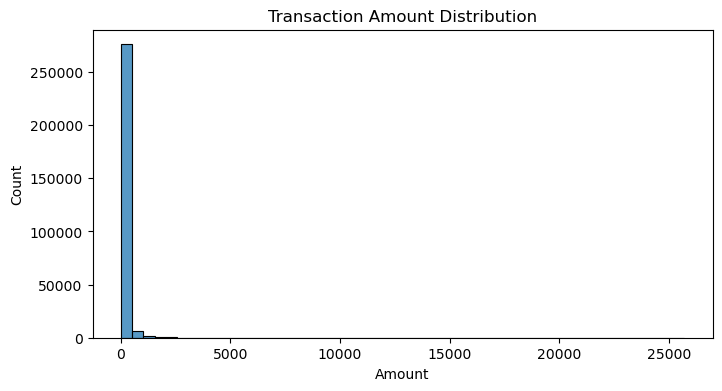

In [5]:
# amount distribution

plt.figure(figsize=(8, 4))  #sets plot size (8in wide, 4 in tall)
sns.histplot(df['Amount'], bins=50)  #plots histogram of transaction amounts #bins=50 means range of values is split into 50 intervals
plt.title("Transaction Amount Distribution")
plt.show()

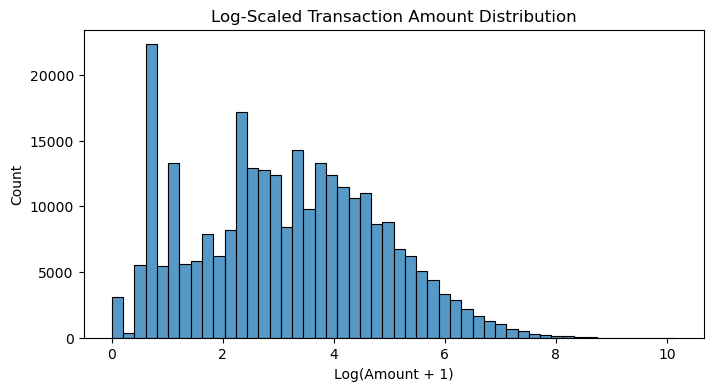

In [6]:
# log-scaled amount distribution

plt.figure(figsize=(8, 4))
sns.histplot(np.log1p(df['Amount']), bins=50)  #log1p is used to handle zero values since log(0) is undefined #applies log(x+1)
plt.title("Log-Scaled Transaction Amount Distribution")
plt.xlabel("Log(Amount + 1)")
plt.show()

In [7]:
# shows range and frequesncy of transaction values
# fraud transactions have unusual amounts (usually very high)
# normalize or scale Amount ?

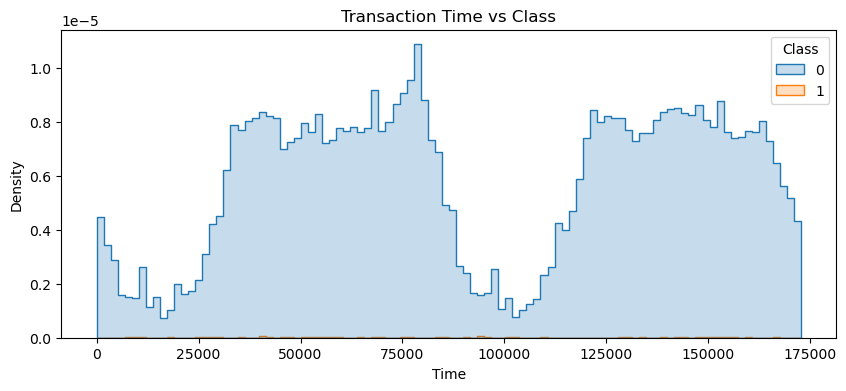

In [8]:
# time vs class

plt.figure(figsize=(10, 4))
sns.histplot(data=df, x='Time' , hue='Class', bins=100, element='step', stat='density') 
#x='Time' → Uses the Time column
#hue='Class' → Plots two overlapping histograms: 0 and 1
#bins=100 → Breaks the time span into 100 intervals for higher resolution.
#element='step' → Draws step-style outlines instead of filled bars, so overlap is visible.
#stat='density' → Normalizes the histogram so the shape matters, not raw counts
plt.title("Transaction Time vs Class")
plt.show()

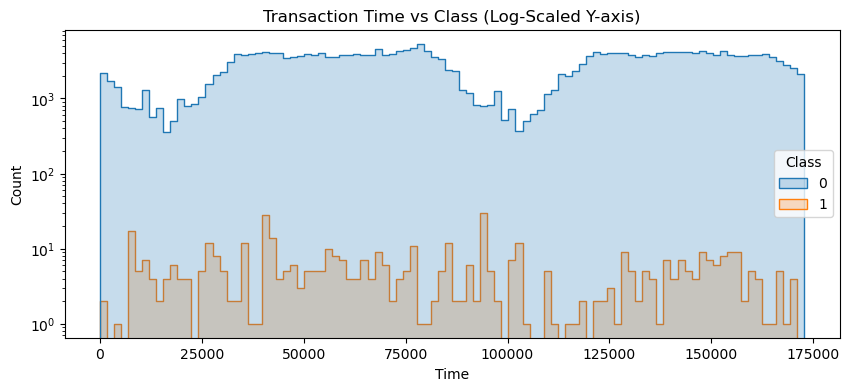

In [9]:
# log-scaled time vs class

plt.figure(figsize=(10, 4))
sns.histplot(data=df, x='Time', hue='Class', bins=100, element='step', stat='count')
#stat='count' → Uses raw counts instead of density
plt.yscale('log')  #Transforms y-axis to a logarithmic scale.
plt.title("Transaction Time vs Class (Log-Scaled Y-axis)")
plt.show()

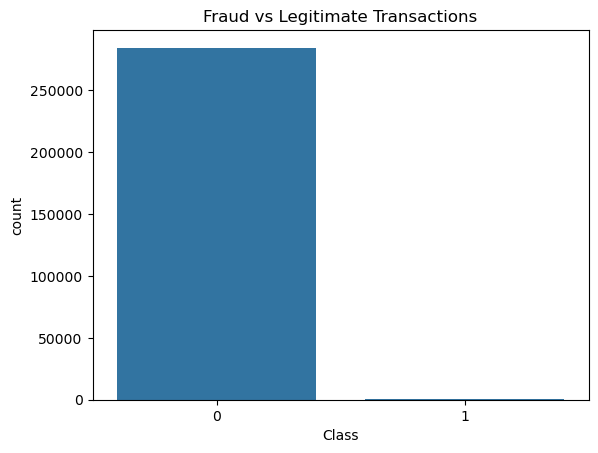

In [10]:
# class count

sns.countplot(x='Class', data=df) #plots number of observations for each class
#x='Class' → Groups data by the target column
#y-axis → Count of samples

plt.title("Fraud vs Legitimate Transactions")
plt.show()

In [11]:
#preprocessing
scaler = StandardScaler() 
df['scaled_time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1)) 
df['scaled_amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))

# Drop original Time and Amount 
df = df.drop(['Time', 'Amount'], axis=1)

# Move scaled columns next to the others 
scaled_cols = ['scaled_time', 'scaled_amount'] 
df = pd.concat([df.drop(scaled_cols, axis=1), df[scaled_cols]], axis=1) 
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_time,scaled_amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,-1.996583,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-1.996583,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,-1.996562,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,-1.996562,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-1.996541,-0.073403


In [12]:
#Train-Test Split 
X = df.drop('Class', axis=1) 
y = df['Class'] 
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42, stratify=y ) 

print("Training set shape:", X_train.shape) 
print("Testing set shape:", X_test.shape) 
print("Fraud cases in training:", sum(y_train)) 
print("Fraud cases in testing:", sum(y_test))

Training set shape: (227845, 30)
Testing set shape: (56962, 30)
Fraud cases in training: 394
Fraud cases in testing: 98


In [13]:
#Handling Imbalance

from collections import Counter

# Check imbalance ratio in training set
counter = Counter(y_train)
majority = counter[0]
minority = counter[1]
imbalance_ratio = majority / minority

print("Class distribution:", counter)
print("Imbalance ratio (majority/minority):", imbalance_ratio)

# This ratio is useful for scale_pos_weight in XGBoost
scale_pos_weight = imbalance_ratio


Class distribution: Counter({0: 227451, 1: 394})
Imbalance ratio (majority/minority): 577.2868020304569


In [14]:
#Logistic Regression Baseline

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Define model with class_weight='balanced' to handle imbalance
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

# Train
log_reg.fit(X_train, y_train)

# Predict
y_pred_lr = log_reg.predict(X_test)

# Evaluation
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

print("\nROC AUC Score:")
print(roc_auc_score(y_test, y_pred_lr))


Confusion Matrix:
[[55475  1389]
 [    8    90]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.98     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.98      0.99     56962


ROC AUC Score:
0.9469703223157581


In [15]:
# Step 6: Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced_subsample',  # handles class imbalance
    n_jobs=-1
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

print("\nROC AUC Score:")
print(roc_auc_score(y_test, y_pred_rf))


Confusion Matrix:
[[56861     3]
 [   24    74]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.96      0.76      0.85        98

    accuracy                           1.00     56962
   macro avg       0.98      0.88      0.92     56962
weighted avg       1.00      1.00      1.00     56962


ROC AUC Score:
0.8775246416799696


In [16]:
# Step 7: Random Forest Hyperparameter Tuning

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced')

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_rf = GridSearchCV(
    rf,
    param_grid_rf,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_rf.fit(X_train, y_train)

print("Best RF Params:", grid_rf.best_params_)
print("Best RF F1 Score:", grid_rf.best_score_)


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best RF Params: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best RF F1 Score: 0.8404799090903957


In [17]:
best_rf = grid_rf.best_estimator_

y_pred_rf = best_rf.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

print("\nROC AUC Score:")
print(roc_auc_score(y_test, best_rf.predict_proba(X_test)[:, 1]))


Confusion Matrix:
[[56859     5]
 [   21    77]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.94      0.79      0.86        98

    accuracy                           1.00     56962
   macro avg       0.97      0.89      0.93     56962
weighted avg       1.00      1.00      1.00     56962


ROC AUC Score:
0.9468468626899269


In [18]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Recalculate scale_pos_weight (ratio of negatives to positives)
from collections import Counter
counts = Counter(y_train)
scale_pos_weight = counts[0] / counts[1]
print("scale_pos_weight:", scale_pos_weight)

# Initialize XGB with imbalance handling
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    eval_metric='auc',
    random_state=42,
    n_jobs=-1
)

# Train
xgb_model.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob_xgb))


scale_pos_weight: 577.2868020304569

Confusion Matrix:
[[56852    12]
 [   16    82]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.87      0.84      0.85        98

    accuracy                           1.00     56962
   macro avg       0.94      0.92      0.93     56962
weighted avg       1.00      1.00      1.00     56962

ROC-AUC Score: 0.9822178660434349


In [19]:
import xgboost as xgb

# Assign your tuned XGBoost model to best_xgb if not already saved
best_xgb = xgb.XGBClassifier(
    scale_pos_weight=577.2868020304569,
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

best_xgb.fit(X_train, y_train)


/opt/anaconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [20:16:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [20]:
# Final Ensemble: Random Forest + XGBoost (Voting Classifier)

# ==========================
# Final Ensemble: RF + XGB
# ==========================

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
import numpy as np

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

# Define your tuned models
best_rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42
)

best_xgb = xgb.XGBClassifier(
    scale_pos_weight=577.2868020304569,
    eval_metric='logloss',
    random_state=42
)

# Ensemble
ensemble_model = VotingClassifier(
    estimators=[
        ('rf', best_rf),
        ('xgb', best_xgb)
    ],
    voting='soft'
)

ensemble_model.fit(X_res, y_res)

# Predict with adjustable threshold
y_proba = ensemble_model.predict_proba(X_test)[:,1]
threshold = 0.3  # adjust to boost fraud recall
y_pred_thresh = (y_proba >= threshold).astype(int)

# Evaluation
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_thresh))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_thresh))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))


Exception ignored in: <function ResourceTracker.__del__ at 0x104a55bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1074ddbc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x107855bc0>
Traceback (most recent call last

Confusion Matrix:
[[56690   174]
 [   13    85]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.33      0.87      0.48        98

    accuracy                           1.00     56962
   macro avg       0.66      0.93      0.74     56962
weighted avg       1.00      1.00      1.00     56962

ROC-AUC: 0.9826137264134691


In [21]:
from sklearn.metrics import f1_score

y_proba = ensemble_model.predict_proba(X_test)[:,1]
thresholds = np.arange(0.1, 0.6, 0.01)
f1_scores = []

for t in thresholds:
    y_pred = (y_proba >= t).astype(int)
    f1_scores.append(f1_score(y_test, y_pred, pos_label=1))

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print("Best Threshold:", best_threshold)
print("F1-score at best threshold:", f1_scores[best_idx])

# Apply best threshold
y_pred_best = (y_proba >= best_threshold).astype(int)
print("\nConfusion Matrix at Best Threshold:")
print(confusion_matrix(y_test, y_pred_best))
print("\nClassification Report at Best Threshold:")
print(classification_report(y_test, y_pred_best))


Best Threshold: 0.5899999999999997
F1-score at best threshold: 0.7248908296943232

Confusion Matrix at Best Threshold:
[[56816    48]
 [   15    83]]

Classification Report at Best Threshold:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.63      0.85      0.72        98

    accuracy                           1.00     56962
   macro avg       0.82      0.92      0.86     56962
weighted avg       1.00      1.00      1.00     56962



In [22]:
import numpy as np

best_threshold = 0.589  # from our previous optimization

def predict_fraud(model, X_new):
    """
    Predict fraud for new transactions.

    Args:
        model : trained ensemble model
        X_new : pandas DataFrame or numpy array of new transaction features

    Returns:
        predictions : 0 (non-fraud) or 1 (fraud)
        probabilities : predicted probability of fraud
    """
    y_proba = model.predict_proba(X_new)[:,1]
    y_pred = (y_proba >= best_threshold).astype(int)
    return y_pred, y_proba



In [23]:
import joblib

# Save each model individually
joblib.dump(best_rf, "best_rf.pkl")
joblib.dump(best_xgb, "best_xgb.pkl")
joblib.dump(best_threshold, "fraud_threshold.pkl")


['fraud_threshold.pkl']

In [24]:
from sklearn.ensemble import VotingClassifier
import joblib

# Load models and threshold
best_rf = joblib.load("best_rf.pkl")
best_xgb = joblib.load("best_xgb.pkl")
best_threshold = joblib.load("fraud_threshold.pkl")

# Recreate the ensemble
ensemble_model = VotingClassifier(
    estimators=[('rf', best_rf), ('xgb', best_xgb)],
    voting='soft'
)

# Optional: fit on SMOTE-resampled data if needed
ensemble_model.fit(X_res, y_res)  # X_res, y_res used during training



VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=10,
                                                     n_estimators=200,
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            feature_types=None,
                                            feature...
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None, ...))],
                 voting='soft')

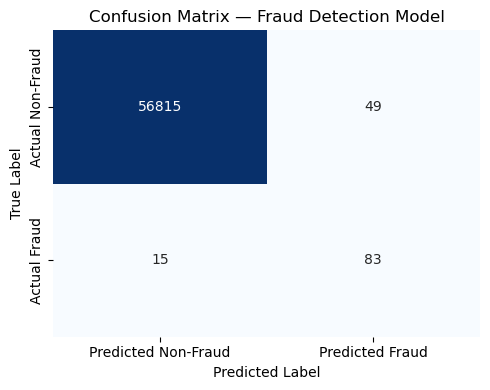

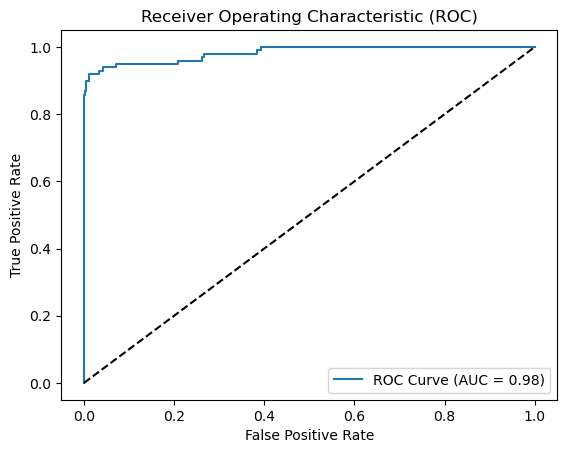

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

# Get predictions with best threshold
y_pred_proba = ensemble_model.predict_proba(X_test)[:, 1]
y_pred_final = (y_pred_proba >= best_threshold).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_final)

# Plot heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Non-Fraud', 'Predicted Fraud'],
            yticklabels=['Actual Non-Fraud', 'Actual Fraud'])
plt.title('Confusion Matrix — Fraud Detection Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # diagonal reference line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [26]:
# Recreate and fit your tuned XGBoost model
import xgboost as xgb

best_xgb = xgb.XGBClassifier(
    scale_pos_weight=577.2868020304569,
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

best_xgb.fit(X_train, y_train)


/opt/anaconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [20:34:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

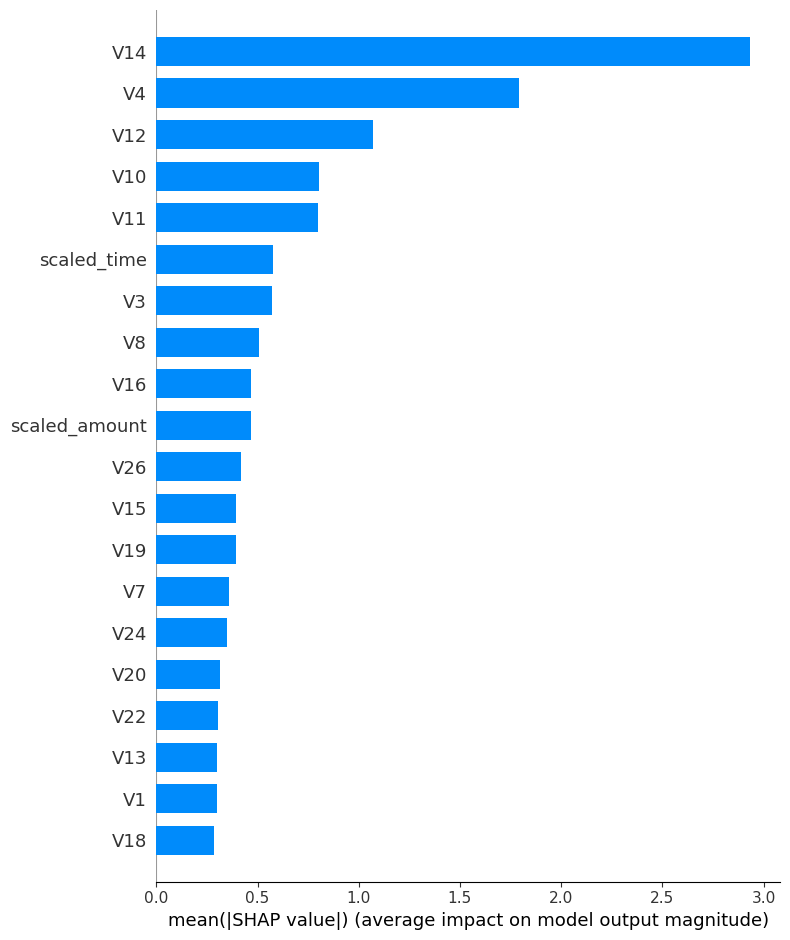

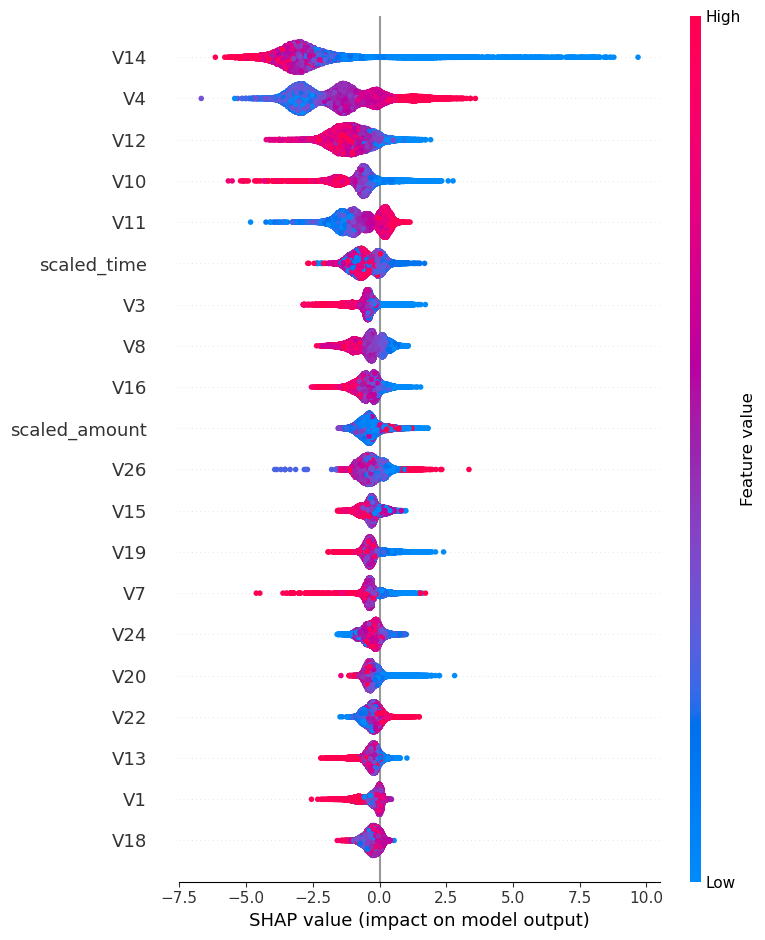

ValueError: visualize() can only display Explanation objects (or arrays of them)!

In [27]:
import shap

# Initialize SHAP explainer (works well with tree models like RandomForest/XGBoost)
explainer = shap.TreeExplainer(best_xgb)  # or best_rf if RandomForest was your final model
shap_values = explainer.shap_values(X_test)

# Summary plot of feature importance
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Detailed summary plot (shows feature impact for all samples)
shap.summary_plot(shap_values, X_test)

# (Optional) Explanation for one random transaction
sample = X_test.sample(1, random_state=42)
shap.force_plot(explainer.expected_value, shap_values[0][0], sample)


In [28]:
# Get predicted probabilities
y_pred_proba = ensemble_model.predict_proba(X_test)[:, 1]

# Apply best threshold
y_pred_final = (y_pred_proba >= best_threshold).astype(int)

# Count detected frauds
total_frauds = sum(y_test)
flagged_frauds = sum((y_test == 1) & (y_pred_final == 1))
missed_frauds = sum((y_test == 1) & (y_pred_final == 0))

print(f"Total fraud cases in test set: {total_frauds}")
print(f"Fraud cases correctly flagged by model: {flagged_frauds}")
print(f"Fraud cases missed: {missed_frauds}")
print(f"Detection Rate: {flagged_frauds / total_frauds * 100:.2f}%")


Total fraud cases in test set: 98
Fraud cases correctly flagged by model: 83
Fraud cases missed: 15
Detection Rate: 84.69%
